In [20]:
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt 
import math
from math import inf
from shapely.geometry import Point, Polygon
from scipy.spatial import ConvexHull

## Nearest Neighbor

In [21]:
two_opt_swap = lambda r,i,k: np.concatenate((r[0:i+1],r[k:i:-1],r[k+1:len(r)]))
def no_loops(data, sorted_data):
    n = len(data)
    x = data[:,0]
    y = data[:,1]
    new = sorted_data.copy()
    flag = True
    it = 0
    while flag and it<50:
        it+=1
        flag = False
        
        xs = x[new]
        ys = y[new]

        a = [ys[i]-ys[i+1] for i in range (n-1)]
        b = [xs[i+1]-xs[i] for i in range (n-1)]
        c = [xs[i]*ys[i+1] - xs[i+1]*ys[i] for i in range (n-1)]
        for i in range (n-3):
            for j in range (i+2, n-1):
                if (b[i]*a[j]-b[j]*a[i]!=0):
                    y_int = (c[j]*a[i]-c[i]*a[j])/(b[i]*a[j]-b[j]*a[i])
                    x_int = (-c[i]-b[i]*y_int)/a[i]
                    if (min(xs[i], xs[i+1]) <= x_int <= max(xs[i], xs[i+1]) and
                        min(xs[j], xs[j+1]) <= x_int <= max(xs[j], xs[j+1])):
                        flag = True
                        new = two_opt_swap(new,i,j)
                        break
            else:
                continue
            break

    return new

In [22]:
def sort_nn(data, sim):
    n = len(data)
    sorted_data = [0]
    while True:
        tmp = inf
        ind = -1    
        for i in range (n):
            if i not in sorted_data:
                if sim[sorted_data[-1],i]<tmp:
                    tmp = sim[sorted_data[-1],i]
                    ind = i
        if len(sorted_data)>10 and sim[sorted_data[-1],0]<tmp:
            break
        if ind>0:
            sorted_data.append(ind)
        else:
            break

    missed_data = np.arange(n)
    md = np.delete(missed_data, missed_data[sorted_data])

    for i in md:
        tmp = inf
        ind = -1
        for j in range (len(sorted_data)-1):
            ij = np.linalg.norm(data[i]-data[sorted_data[j]])
            ij1 = np.linalg.norm(data[i]-data[sorted_data[j+1]])
            if (ij + ij1)<tmp:
                tmp = ij +ij1
                ind = j                                                                         
        if np.linalg.norm(data[i]-data[sorted_data[j]])+np.linalg.norm(data[i]-data[0])<tmp:
            sorted_data.append(i)
        else:
            sorted_data.insert(ind+1,i)
            
    new = no_loops(data, sorted_data)
    
    return new

In [23]:
def sort_2in1(data,sim):
    n = len(data)
    mid = np.argmin(sim[0][4:])
    data1 = data[:mid]
    data2 = data[mid:]

    sorted_data = np.arange(mid)
    missed_data = np.arange(n)
    md = np.delete(missed_data, missed_data[sorted_data])

    for i in md:
        tmp = inf
        ind = -1
        for j in range (len(sorted_data)-1):
            ij = np.linalg.norm(data[i]-data[sorted_data[j]])
            ij1 = np.linalg.norm(data[i]-data[sorted_data[j+1]])
            if (ij + ij1)<tmp:
                tmp = ij +ij1
                ind = j                                                                         
        if np.linalg.norm(data[i]-data[sorted_data[j]])+np.linalg.norm(data[i]-data[0])<tmp:
            sorted_data = np.append(sorted_data,i)
        else:
            sorted_data = np.insert(sorted_data,ind+1,i)

    new = no_loops(data, sorted_data)
    return new

## Sorting by angle

In [24]:
def clockwiseangle_and_distance(point):
    # Vector between point and the origin: v = p - o
    vector = [point[0]-origin[0], point[1]-origin[1]]
    # Length of vector: ||v||
    lenvector = math.hypot(vector[0], vector[1])
    # If length is zero there is no angle
    if lenvector == 0:
        return -math.pi, 0
    # Normalize vector: v/||v||
    normalized = [vector[0]/lenvector, vector[1]/lenvector]
    dotprod  = normalized[0]*refvec[0] + normalized[1]*refvec[1]     # x1*x2 + y1*y2
    diffprod = refvec[1]*normalized[0] - refvec[0]*normalized[1]     # x1*y2 - y1*x2
    angle = math.atan2(diffprod, dotprod)
    # Negative angles represent counter-clockwise angles so we need to subtract them 
    # from 2*pi (360 degrees)
    if angle < 0:
        return 2*math.pi+angle, lenvector
    # I return first the angle because that's the primary sorting criterium
    # but if two vectors have the same angle then the shorter distance should come first.
    return angle, lenvector


def sort_angle(data,sim):
    global origin, refvec
    origin = [np.sum(data[:, 0])/len(data),np.sum(data[:, 1])/len(data)]
    refvec = [0,1]
    angle = np.array([clockwiseangle_and_distance(point) for point in data])
    
    sort = sorted(data, key=clockwiseangle_and_distance)

    sort = np.argsort(angle[:,0])
#     sort = np.array(sort)
    return sort

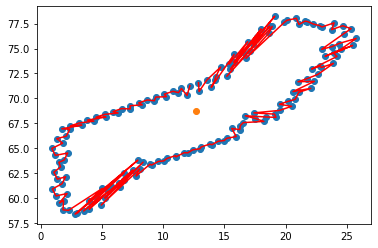

In [25]:
data = pd.read_table("data1/1.1.dat", sep=' ', header=None)
data = data.to_numpy()

n = len(data)
sim =np.array([[np.linalg.norm(data[i]-data[j]) for i in range (n)] for j in range (n)])

sort = sort_angle(data,sim)
plt.scatter(data[:,0],data[:,1])
plt.plot(data[sort,0],data[sort,1],'r')
# plt.plot(sort[:,0],sort[:,1],'r')
plt.scatter(origin[0],origin[1])
plt.show()

## Inserting intersection bounds into union bounds

In [26]:
def split_2_contours(data,sim):
    # split data in two contours
    mid = np.argmin(sim[0][4:])-10
    mid = 5
    while mid<len(data)-10:
        data1 = data[:mid]
        data2 = data[mid:]

        arr1 = [Point(data1[i][0],data1[i][1]) for i in range (len(data1))]
        arr1.append(arr1[0])
        arr2 = [Point(data2[i][0],data2[i][1]) for i in range (len(data2))]
        arr2.append(arr2[0])
        lr1 = Polygon(arr1)
        lr2 = Polygon(arr2)

        if lr1.is_valid and lr2.is_valid:
            break
        mid += 1

    if mid==len(data)-10:
        mid = np.argmin(sim[0][4:])+2
        data1 = data[:mid]
        data2 = data[mid:]

        arr1 = [Point(data1[i][0],data1[i][1]) for i in range (len(data1))]
        arr1.append(arr1[0])
        arr2 = [Point(data2[i][0],data2[i][1]) for i in range (len(data2))]
        arr2.append(arr2[0])
        lr1 = Polygon(arr1)
        lr2 = Polygon(arr2)
    
    if not lr1.is_valid:
        mid = np.argmin(sim[0][4:])+2
        data1 = data[no_loops(data[:mid],list(range(mid)))]
        arr1 = [Point(data1[i][0],data1[i][1]) for i in range (len(data1))]
        arr1.append(arr1[0])
        lr1 = Polygon(arr1)

    if not lr2.is_valid:
        mid = np.argmin(sim[0][4:])+2
        ind = no_loops(data[mid:],list(range(len(data)-mid)))
        ind = np.array(ind)+mid
        data2 = data[ind]
        arr2 = [Point(data2[i][0],data2[i][1]) for i in range (len(data2))]
        arr2.append(arr2[0])
        lr2 = Polygon(arr2) 

    
    return lr1, lr2


def get_union_intersction(data,sim):
    lr1,lr2 = split_2_contours(data,sim)
    ux,uy = lr1.union(lr2).boundary.coords.xy
    union_data = np.array([-1]*len(ux))
    ix,iy = lr1.intersection(lr2).boundary.coords.xy
    intersect_data = np.array([-1]*len(ux))
    eps = 0.0001
    for i in range(len(data)):
        for j in range(len(ux)):
            if abs(ux[j]-data[i,0])<=eps and abs(uy[j]-data[i,1])<=eps:
                union_data[j] = i
    #             break
        for j in range(len(ix)):
            if abs(ix[j]-data[i,0])<=eps and abs(iy[j]-data[i,1])<=eps:
                intersect_data[j] = i
    #             break

    union_data = union_data[union_data>-1]
    union_data = union_data[:-1]

    intersect_data = intersect_data[intersect_data>-1]
    intersect_data = intersect_data[:-1]
    return union_data, intersect_data

    
def sort_union_intersection(data,sim):
    union_data, intersect_data = get_union_intersction(data, sim)
    sort_ui = union_data
    intersect_data = np.append(intersect_data,list(set(range(len(data)))-(set(union_data)|set(intersect_data))))
    intersect_data = intersect_data.astype(int)

    for el in intersect_data:
        ij = np.linalg.norm(data[el]-data[sort_ui[:-1]],axis=1)
        ij1 = np.linalg.norm(data[el]-data[sort_ui[1:]],axis=1)
        ij = ij + ij1
    #     ind = np.where(ij==np.amin(ij))[0][0]
        ind = np.argmin(ij)
        sort_ui = np.insert(sort_ui,ind+1,el)
        
    return sort_ui    

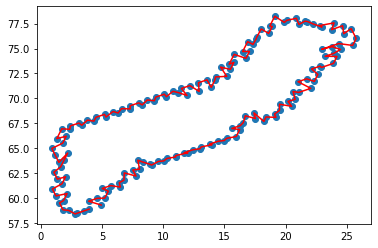

In [27]:
data = pd.read_table("data1/1.1.dat", sep=' ', header=None)
global idata
# idata = 3
data = data.to_numpy()

n = len(data)
sim =np.array([[np.linalg.norm(data[i]-data[j]) for i in range (n)] for j in range (n)])

sort = sort_union_intersection(data,sim)
plt.scatter(data[:,0],data[:,1])
plt.plot(data[sort,0],data[sort,1],'r')
# plt.plot(sort[:,0],sort[:,1],'r')
# plt.scatter(origin[0],origin[1])
plt.show()

## Statistic

In [28]:
def calc_path(sorted, data):
    path = 0
    for i in range (len(data)-1):
        path += np.linalg.norm(data[sorted[i+1]]-data[sorted[i]])
    path += np.linalg.norm(data[sorted[-1]]-data[sorted[0]])
  
    return path

In [29]:
algorithms = [sort_nn, sort_2in1, sort_angle, sort_union_intersection]
results = {}
datas = []
for idata in [1,6,9,10,11,12,13]:
    data = pd.read_table("data1/"+str(idata)+".1.dat", sep=' ', header=None)
    datas.append(data.to_numpy())
for idata in range (1,14):
    data = pd.read_table("data/"+str(idata)+".dat", sep=' ', header=None)
    datas.append(data.to_numpy())
    
for ind,data in enumerate(datas):
    res = []
#     print(ind+1)
    n = len(data)
    sim =np.array([[np.linalg.norm(data[i]-data[j]) for i in range (n)] for j in range (n)])
    for i, alg in enumerate(algorithms[:-1]):

        sort = alg(data,sim)
        res.append(calc_path(sort, data))
    flag = 1
    try:
        sort = sort_union_intersection(data,sim)
    except:
        flag = 0
    if flag:
        res.append(calc_path(sort,data))
    else:
        res.append('Ошибка при построении внешней границы')
        
    results[ind+1] = res

TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4.1541980420384252 60.286048373359719 at 4.1541980420384252 60.286048373359719
TopologyException: Input geom 0 is invalid: Self-intersection at or near point 24.654410000000002 77.289509999999993 at 24.654410000000002 77.289509999999993
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 3.3970860035371184 60.145096027949066 at 3.3970860035371184 60.145096027949066


In [30]:
alg_name = ['Улучшенный алгоритм ближайшего соседа', 'Вставка второго контура в первый','Сортировка по полярным координатам','Вставка внутренних точек во внешнюю границу']
df = pd.DataFrame(data=results).T  
df.columns = alg_name
# df.index = range(1,len(results)+1)
df

,Улучшенный алгоритм ближайшего соседа,Вставка второго контура в первый,Сортировка по полярным координатам,Вставка внутренних точек во внешнюю границу
1,107.346,112.663,214.703,110.137
2,108.103,115.742,160.168,118.125
3,122.831,122.098,225.692,124.865
4,121.761,123.836,223.932,122.013
5,105.825,112.47,151.624,112.773
6,116.247,131.037,206.479,Ошибка при построении внешней границы
7,117.453,122.17,210.883,Ошибка при построении внешней границы
8,113.763,123.298,354.842,116.404
9,180.971,131.478,419.436,134.109
10,121.233,129.062,361.1,Ошибка при построении внешней границы


In [31]:
# df.to_excel('results.xlsx')

## Convex Hull

In [32]:
def sort_ch(data, sim):
    centroid = [np.sum(data[:, 0])/len(data),np.sum(data[:, 1])/len(data)]
    hull = ConvexHull(data)
    del_points = hull.vertices
    sort_convex = hull.vertices
    sort_convex = np.append(sort_convex,sort_convex[0])
    mask = np.copy(data)
    
    for i in range(len(data)):
        x = data[del_points[i],0]
        y = data[del_points[i],1]
        mask[del_points[i]]=[centroid[0]+0.01*(x-centroid[0]),centroid[1]+0.01*(y-centroid[1])]
        hull1 = ConvexHull(mask)
        new_points = []
        for point in hull1.vertices:
            if int(point) not in del_points:
                new_points.append(point)
        new_points = np.array(new_points).astype(int)
        del_points = np.append(del_points,new_points)

        for new_point in new_points:
            dist = [sim[new_point,sort_convex[j]]+sim[new_point,sort_convex[j-1]] 
                   for j in range(1, len(sort_convex))]
            new_cons_ind = np.argmin(dist)
            sort_convex = np.insert(sort_convex,new_cons_ind+1,new_point)

        sort_convex = sort_convex[no_loops(data[sort_convex], list(range(len(sort_convex))))]
  
        if len(del_points)>=len(data)-3:
            break

    missed_data = list(set(range(len(data)))-set(sort_convex))
    for el in missed_data:
        dist = [sim[el,sort_convex[j]]+sim[el,sort_convex[j-1]] 
            for j in range(1, len(sort_convex))]
        new_cons_ind = np.argmin(dist)
        sort_convex = np.insert(sort_convex,new_cons_ind+1,new_point)
        
    return sort_convex

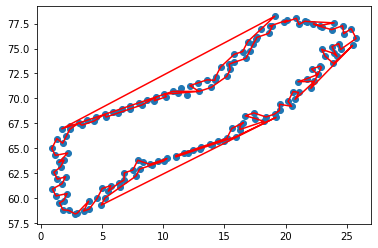

In [33]:
data = pd.read_table("data1/1.1.dat", sep=' ', header=None)
data = data.to_numpy()

n = len(data)
sim =np.array([[np.linalg.norm(data[i]-data[j]) for i in range (n)] for j in range (n)])

sort = sort_ch(data,sim)
plt.scatter(data[:,0],data[:,1])
plt.plot(data[sort,0],data[sort,1],'r')
plt.show()